# 0) Imports & dataset loading

In [4]:
use_google_colab = True
if use_google_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd "/gdrive/MyDrive/Colab Notebooks/Scientific Computing Tools for Advanced Mathematical Modeling/FinalProject"

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import euclidean_distances
from time import time
from tqdm import tqdm
from sys import getsizeof

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/Scientific Computing Tools for Advanced Mathematical Modeling/FinalProject


Dataset Loading

In [5]:
print("loading the dataset")
df_og = pd.read_csv('LAsignals.csv')
# remove index column
df_og = df_og.iloc[:,-len(df_og.columns.values)+1:]
# tidy the dataset
signals = df_og.iloc[:,6:].values
coordinates = df_og.iloc[:,:3]
coordinates = coordinates.values.astype('<f4')
IIR = df_og.iloc[:,5].values.astype('<f2')

loading the dataset


# 1) Dimensionality Reduction

Instead of working with a large dataset full of redundant information, we decided to look for features in the signals which might be able to help distinguishing between "Normal" and "Abnormal" signals. 

In [6]:
dataset = np.zeros((coordinates.shape[0],10))
dataset[:,0] = np.max(signals, axis = 1) #max amplitude of the signal
dataset[:,1] = np.min(signals, axis = 1) #min amplitude of the signal
dataset[:,2] = np.var(signals, axis = 1) #variance of the signal
dataset[:,3] = np.max(np.diff(signals), axis = 1) #max amplitude derivative of the signal
dataset[:,4] = np.min(np.diff(signals), axis = 1) #min amplitude derivative of the signal
dataset[:,5] = np.argmax(signals, axis = 1) #position max amplitude peak 
dataset[:,6] = np.argmin(signals, axis = 1) #position min amplitude peak
dataset[:,7] = IIR 
dataset[:,8] = stats.kurtosis(signals, axis = 1)
dataset[:,9] = stats.skew(signals, axis = 1)

data = pd.DataFrame(dataset, columns=["max_ampl", "min_ampl", "var", "max_ampl_der", "min_ampl_der", "position_max", "position_min", "IIR", "kurtosis", "skewness"])
data.info()
# Check if there are None or Null values

col = ["Abnormal"]*coordinates.shape[0]
col = np.array(col)
col[IIR <=1.22] = "Normal"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145134 entries, 0 to 145133
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   max_ampl      145134 non-null  float64
 1   min_ampl      145134 non-null  float64
 2   var           145134 non-null  float64
 3   max_ampl_der  145134 non-null  float64
 4   min_ampl_der  145134 non-null  float64
 5   position_max  145134 non-null  float64
 6   position_min  145134 non-null  float64
 7   IIR           145134 non-null  float64
 8   kurtosis      145134 non-null  float64
 9   skewness      145134 non-null  float64
dtypes: float64(10)
memory usage: 11.1 MB


In [7]:
data.describe()

,max_ampl,min_ampl,var,max_ampl_der,min_ampl_der,position_max,position_min,IIR,kurtosis,skewness
count,145134.000000,145134.000000,145134.000000,145134.000000,145134.000000,145134.000000,145134.000000,145134.000000,145134.000000,145134.000000
mean,0.815760,-1.350414,0.017773,0.695441,-1.659878,110.467857,111.235217,1.089228,100.801847,-1.306411
std,0.464093,0.846605,0.016162,0.294594,0.853951,76.025044,76.225802,0.149496,16.188215,6.505605
min,0.036770,-6.200027,0.000471,0.054154,-6.317674,0.000000,0.000000,0.391846,12.609745,-16.161964
25%,0.229287,-2.192986,0.008533,0.519978,-2.374973,39.000000,39.000000,0.998047,98.371331,-10.036645
50%,0.998803,-1.209097,0.010920,0.584988,-2.063387,110.000000,111.000000,1.074219,103.847032,-0.671689
75%,1.199671,-1.008357,0.031040,0.979016,-1.025775,165.000000,165.000000,1.162109,108.281219,3.808217
max,4.386434,-0.030759,0.247865,2.845643,-0.035938,399.000000,399.000000,1.845703,279.044582,13.673266


Our assumption is that "Normal" signals are characterised by IIR $\leq$ 1.22, while "Abnormal" signals have IIR > 1.22

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


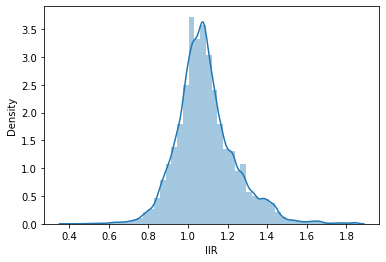

In [8]:
sns.distplot(data['IIR'])

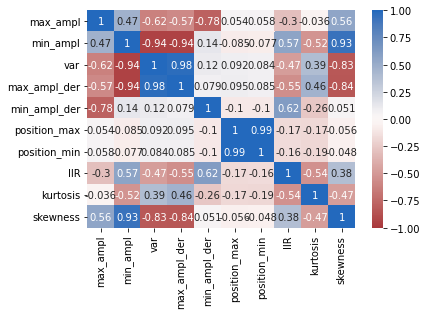

In [9]:
sns.heatmap(data.corr(), annot = True, cmap = 'vlag_r', vmin = -1, vmax = 1)

the extracted features seem to be correlated with the IIR index

# 2) Visual Analysis

## 2.1) Pairplot with all the variables

Let's observe a pairplot of the chosen variables colored with the IIR index.

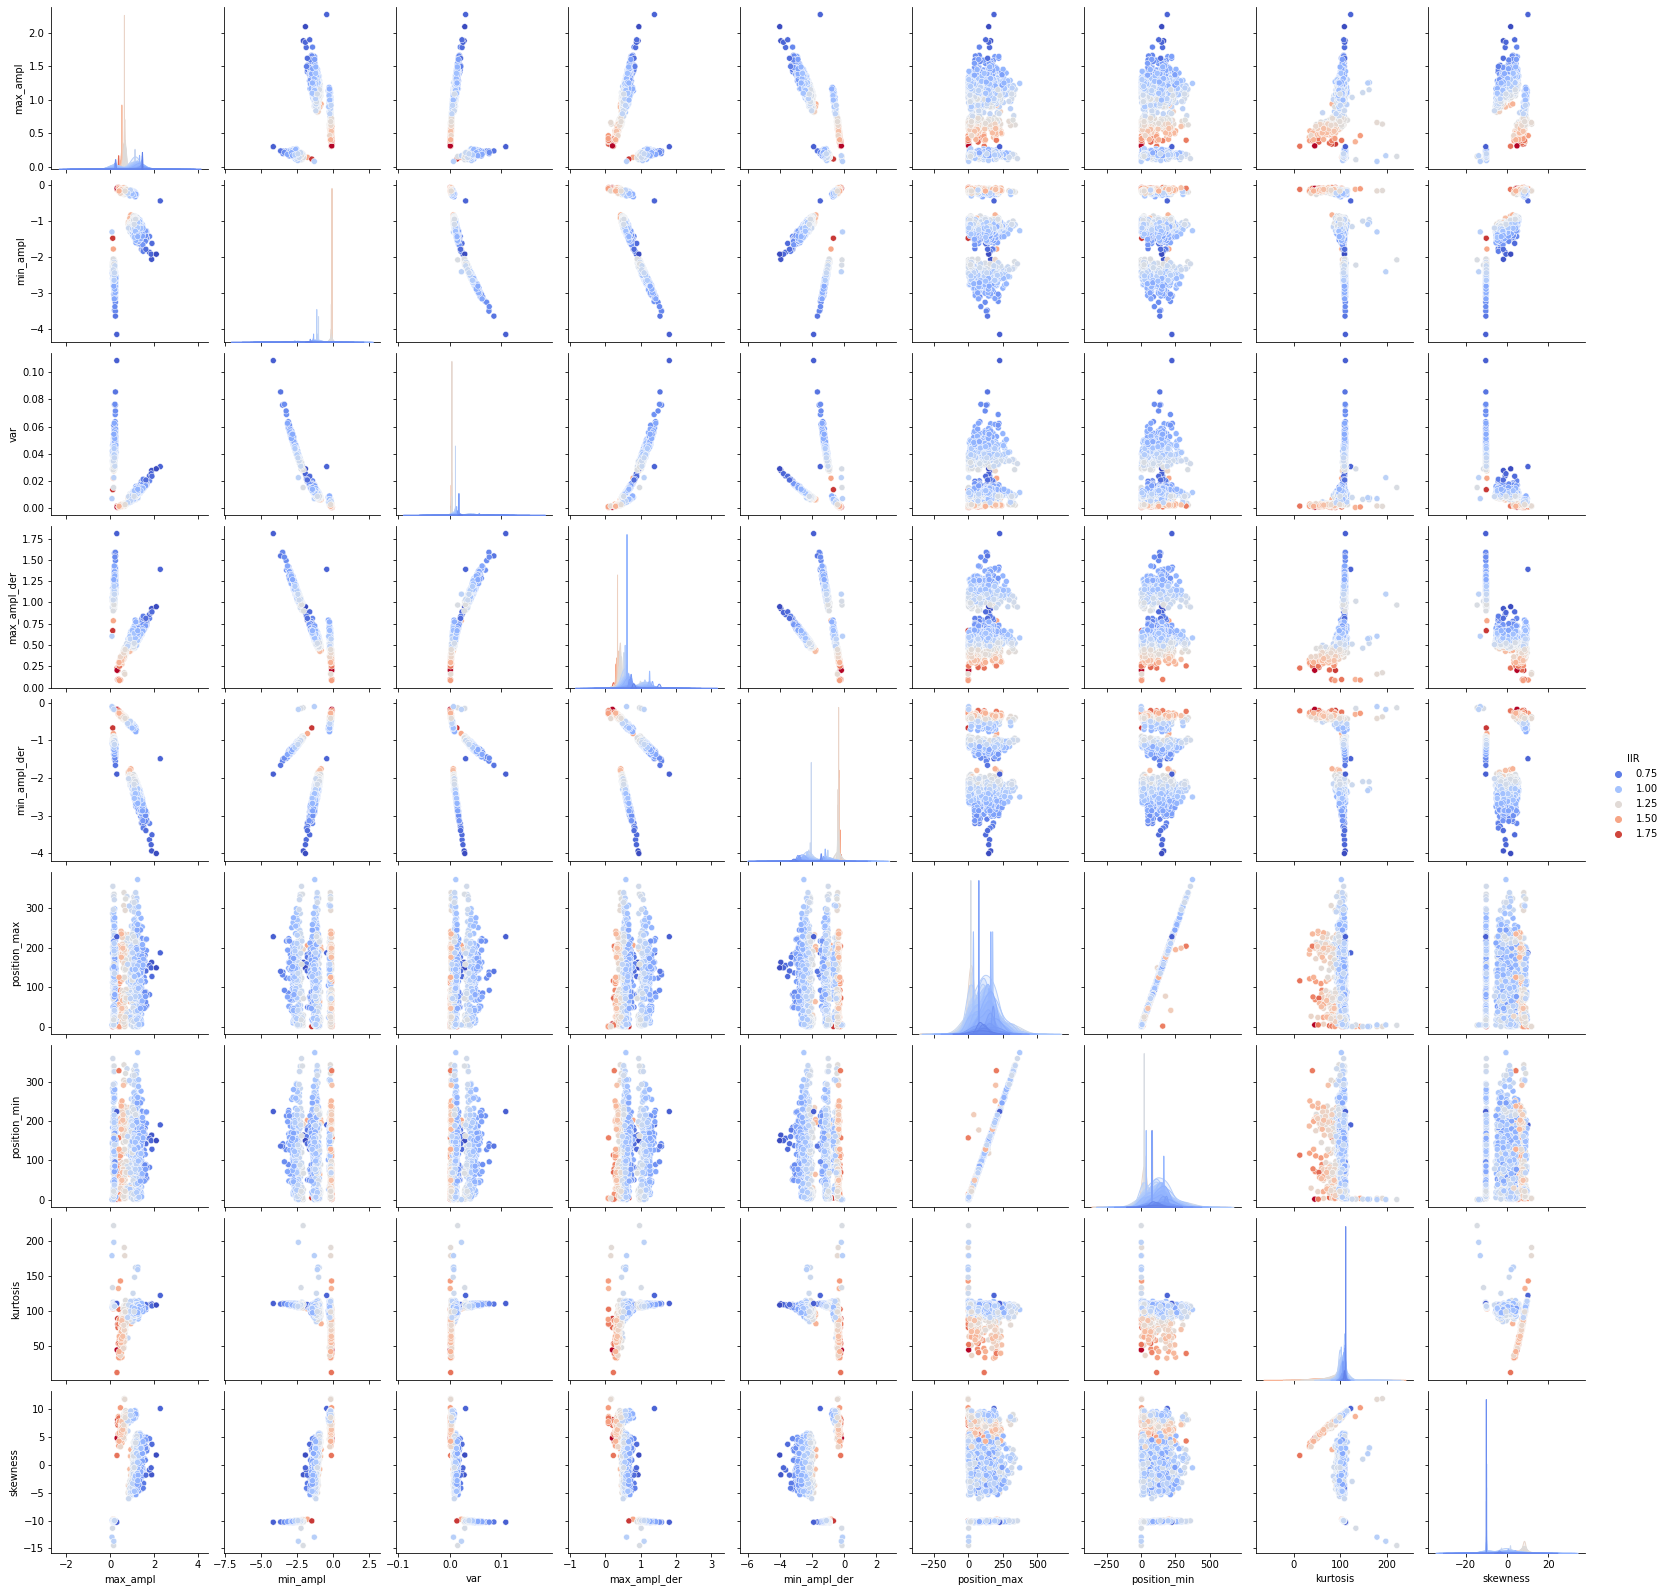

In [10]:
sns.pairplot(data = data.iloc[::100, :], hue = "IIR", palette = "coolwarm")
# Due to limited computational capacity we are able to show the pairplot only for 1/100 of the dataset.
# Interesting patterns will be analysed later

## 2.2) max amplitude vs min amplitude

Text(0.5, 1.0, 'Only Normal')

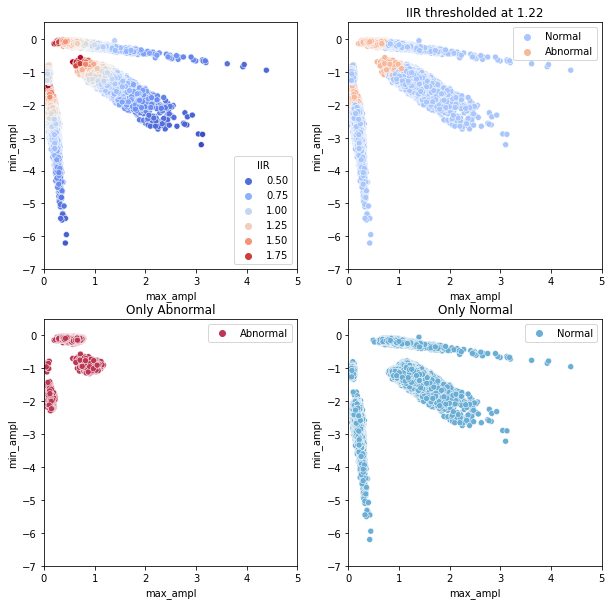

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
vmin = np.min(IIR)
vmax = np.max(IIR)
scatter = sns.scatterplot(data = data, x='max_ampl' ,y='min_ampl', hue='IIR', palette = "coolwarm", vmin = vmin, vmax = vmax)
scatter.set_xlim(left=0, right=5)
scatter.set_ylim(bottom=-7, top=0.5)

plt.subplot(2,2,2)

scatter = sns.scatterplot(data = data, x='max_ampl' ,y='min_ampl', hue=col, palette = "coolwarm", vmin = vmin, vmax = vmax)
scatter.set_xlim(left=0, right=5)
scatter.set_ylim(bottom=-7, top=0.5)
scatter.set_title("IIR thresholded at 1.22")


plt.subplot(2,2,3)
scatter =sns.scatterplot(data = data.iloc[col == "Abnormal"], x='max_ampl' ,y='min_ampl', hue=col[col == "Abnormal"], palette = "inferno")
scatter.set_xlim(left=0, right=5)
scatter.set_ylim(bottom=-7, top=0.5)
scatter.set_title("Only Abnormal")


plt.subplot(2,2,4)
scatter =sns.scatterplot(data = data.iloc[col == "Normal"], x='max_ampl' ,y='min_ampl', hue=col[col == "Normal"], palette = "Blues")
scatter.set_xlim(left=0, right=5)
scatter.set_ylim(bottom=-7, top=0.5)
scatter.set_title("Only Normal")


the anomalies seems to be concentrated in a region with small **max amplitude** and **min amplitude**

## 2.3) max amplitude vs min amplitude (derivative)

Text(0.5, 1.0, 'Only Normal')

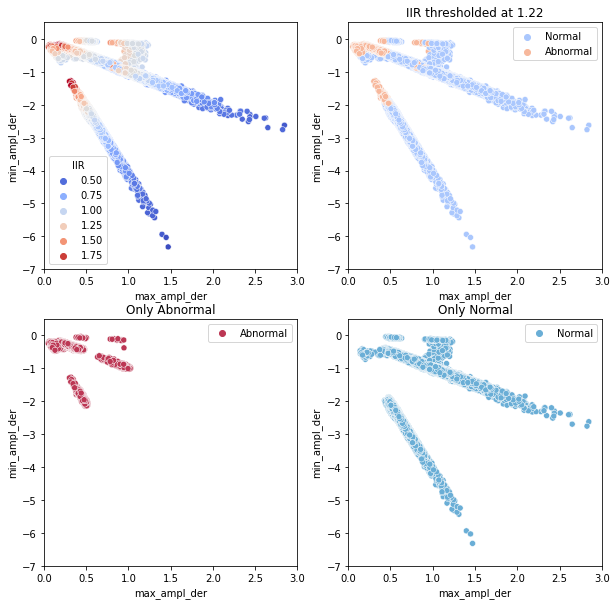

In [12]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
scatter = sns.scatterplot(data = data, x='max_ampl_der' ,y='min_ampl_der', hue='IIR', palette = "coolwarm", vmin = vmin, vmax = vmax)
scatter.set_xlim(left=0, right=3)
scatter.set_ylim(bottom=-7, top=0.5)


plt.subplot(2,2,2)
scatter = sns.scatterplot(data = data, x='max_ampl_der' ,y='min_ampl_der', hue=col, palette = "coolwarm", vmin = vmin, vmax = vmax)
scatter.set_xlim(left=0, right=3)
scatter.set_ylim(bottom=-7, top=0.5)
scatter.set_title("IIR thresholded at 1.22")


plt.subplot(2,2,3)
scatter = sns.scatterplot(data = data.iloc[col == "Abnormal",:], x='max_ampl_der' ,y='min_ampl_der',hue =col[col == "Abnormal"], palette = "inferno")
scatter.set_xlim(left=0, right=3)
scatter.set_ylim(bottom=-7, top=0.5)
scatter.set_title("Only Abnormal")


plt.subplot(2,2,4)
scatter = sns.scatterplot(data = data.iloc[col == "Normal",:], x='max_ampl_der' ,y='min_ampl_der',hue = col[col == "Normal"], palette = "Blues")
scatter.set_xlim(left=0, right=3)
scatter.set_ylim(bottom=-7, top=0.5)
scatter.set_title("Only Normal")


Even for the *derivative* of the signals, the anomalies seems to be concentrated in a region with small **max amplitude** and **min amplitude**

## 2.4) position max peak vs position min peak

Text(0.5, 1.0, 'Only Normal')

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


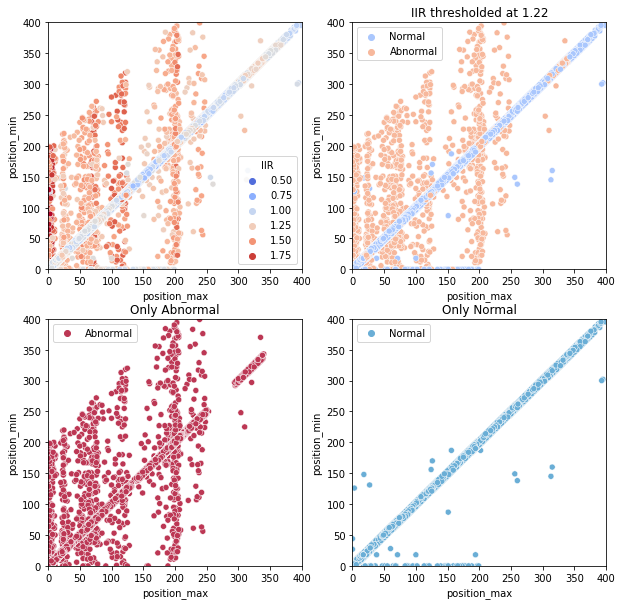

In [13]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
scatter = sns.scatterplot(data = data, x='position_max' ,y='position_min', hue='IIR', palette = "coolwarm", vmin = vmin, vmax = vmax)
scatter.set_xlim(left=0, right=400)
scatter.set_ylim(bottom=0, top=400)


plt.subplot(2,2,2)
scatter =sns.scatterplot(data = data, x='position_max' ,y='position_min', hue=col, palette = "coolwarm", vmin = vmin, vmax = vmax)
scatter.set_xlim(left=0, right=400)
scatter.set_ylim(bottom=0, top=400)
scatter.set_title("IIR thresholded at 1.22")


plt.subplot(2,2,3)
scatter = sns.scatterplot(data = data.iloc[col=="Abnormal",:], x='position_max' ,y='position_min', hue=col[col=="Abnormal"], palette = "inferno")
scatter.set_xlim(left=0, right=400)
scatter.set_ylim(bottom=0, top=400)
scatter.set_title("Only Abnormal")



plt.subplot(2,2,4)
scatter = sns.scatterplot(data = data.iloc[col=="Normal",:], x='position_max' ,y='position_min', hue=col[col=="Normal"], palette = "Blues")
scatter.set_xlim(left=0, right=400)
scatter.set_ylim(bottom=0, top=400)
scatter.set_title("Only Normal")


the normal signals seem to have the max and min amplitude peaks very closed together

## 2.5) variance vs IIR

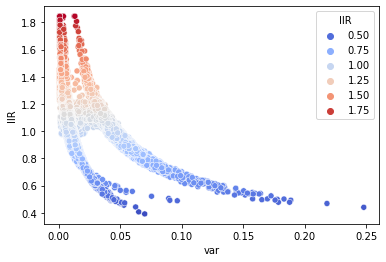

In [14]:
sns.scatterplot(data = data, x = "var", y = "IIR", hue = "IIR", palette = "coolwarm", vmin = vmin, vmax = vmax)

The anomalies have in general a small variance of the signal

## 2.6) kurtosis and skewness density

[Text(0.5, 1.0, 'skewness')]

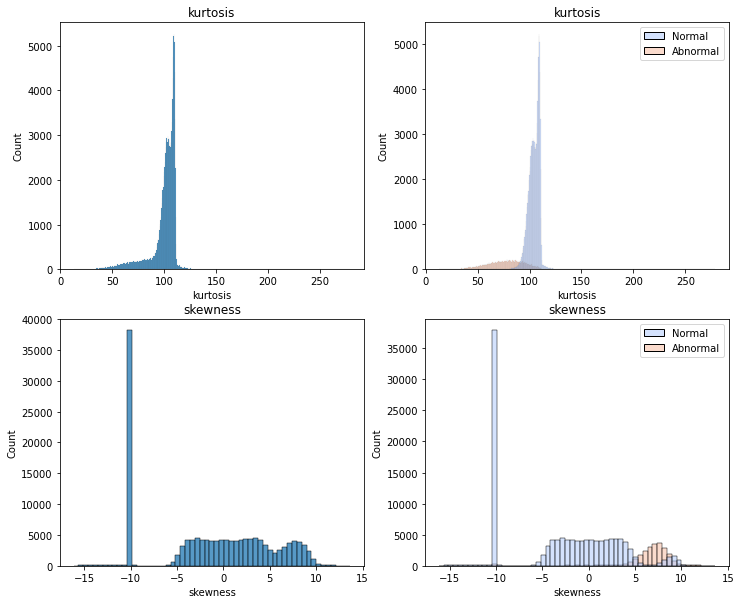

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(data, x = "kurtosis",ax = axes[0,0]).set(title='kurtosis')
sns.histplot(data, x = "kurtosis", hue = col, palette = "coolwarm", ax = axes[0,1]).set(title='kurtosis')
sns.histplot(data, x = "skewness",ax = axes[1,0]).set(title='skewness')
sns.histplot(data, x = "skewness", hue = col, palette = "coolwarm", ax = axes[1,1]).set(title='skewness')

An extreme positive kurtosis indicates a distribution where most of the numbers are located in the tails of the distribution instead of around the mean. This is what we expect given the impulsive nature of the signals.  
In particular:

*   *Normal* signals tend to have a higher kurtosis and so more prominent peaks with small values around them.

*   *Abnormal* signals tend to have lower kurtosis and so lower peaks (we have already seen that this signals have smaller variances).

On the other hand the skewness suggests that *Abnormal* signals always have a mean amplitude value larger than their median amplitude value, while this is not true in general for *Normal* signals.

## Conclusions of the visual analisys

Anomalies seems to be closer to flat signals, with small-amplitude peaks and a small variance.

We will proceed looking at some plots of the signals to proove these conclusions.

In [16]:
idx = [str(i) for i in range(1, 401)]
names = ["X", "Y", "Z", "UAC1", "UAC2", "IIR"]
names.extend(idx)
df_og.columns = names

ordered_signals = df_og.sort_values("IIR")

### Plots of the signals

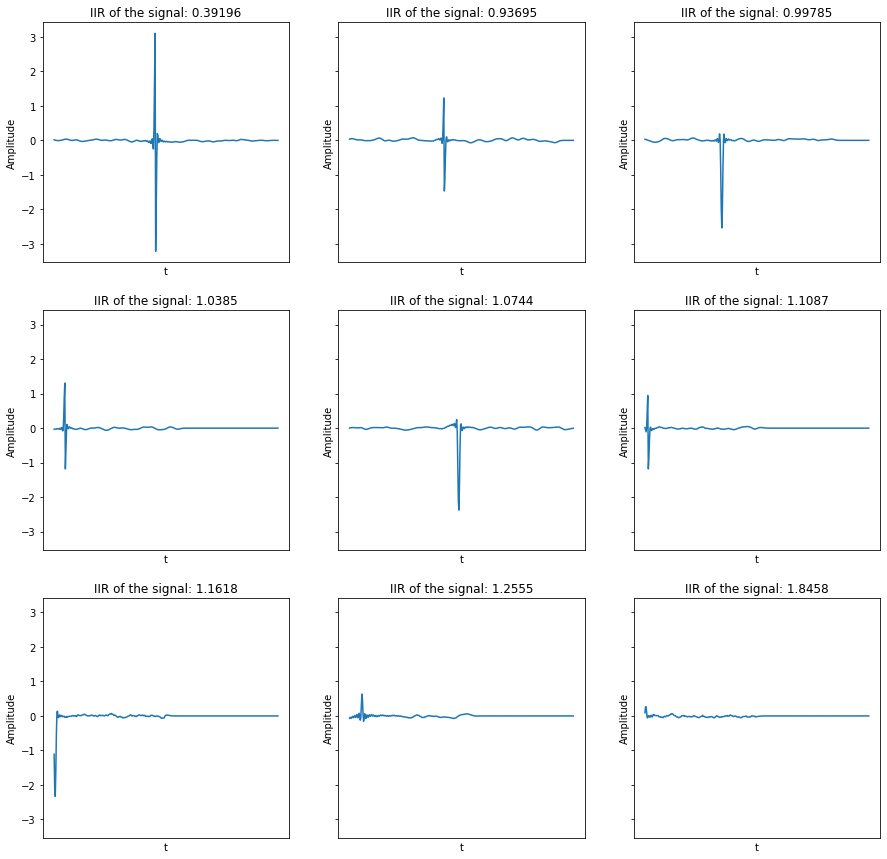

In [17]:
m = 3
n = 3
fig,ax = plt.subplots(m,n, figsize = (m*5,n*5), sharey = True)

counter = 0
for i in range(m):
  for j in range(n):
    ax[i,j].plot(ordered_signals.iloc[counter,6:])  
    ax[i,j].set_ylabel('Amplitude')
    ax[i,j].set_xlabel('t')
    ax[i,j].set_title("IIR of the signal: " + str(ordered_signals.IIR.values[counter]))
    # Turn off tick labels
    ax[i,j].set_xticklabels([0, 100, 200, 300, 400])
    ax[i,j].set_xticks([])
    counter += int(data.shape[0]/(m*n-1)) -1

The conclusions we drew seem correct

### simple classifiers

we built some simple classifiers to further check if the extracted features are useful for our clustering problem

Text(0.5, 1.0, 'Thresholding max_ampl_der')

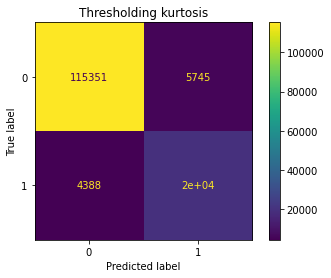

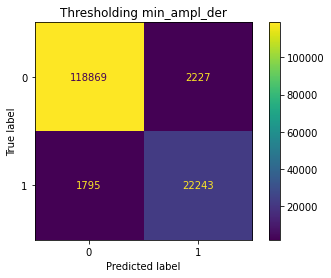

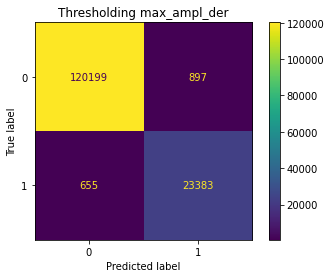

In [18]:
true_labels = np.zeros((coordinates.shape[0],1))
true_labels[IIR>1.22] = 1

final_labels = np.zeros((coordinates.shape[0],1))
final_labels[(data.iloc[:,-2].values < 95) ] = 1
m =confusion_matrix(true_labels, final_labels)
disp = ConfusionMatrixDisplay(m)
disp.plot()
disp.ax_.set_title("Thresholding kurtosis")

final_labels = np.zeros((coordinates.shape[0],1))
final_labels[(data.min_ampl.values > -0.19) ] = 1 
m =confusion_matrix(true_labels, final_labels)
disp = ConfusionMatrixDisplay(m)
disp.plot()
disp.ax_.set_title("Thresholding min_ampl_der")



final_labels = np.zeros((coordinates.shape[0],1))
final_labels[(data.max_ampl_der.values < 0.47) ] = 1 
m =confusion_matrix(true_labels, final_labels)
disp = ConfusionMatrixDisplay(m)
disp.plot()
disp.ax_.set_title("Thresholding max_ampl_der")